In [1]:
import datetime as dt
dt.datetime(2021, 9, 13) + dt.timedelta(42)

datetime.datetime(2021, 10, 25, 0, 0)

In [93]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import glob

pd.set_option('display.max_rows',None)

datas =[]
for idx, file in enumerate(glob.glob("Preprocess/*.csv")):
    if idx == 19:
        continue
    tmp = pd.read_csv(file, header =0, index_col = 0)
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"])
    start = tmp.iloc[0]["timestamp"]
    tmp.insert(0, "day", [(timestamp.date()- start.date()).days for timestamp in tmp["timestamp"]])
    index= list(tmp.groupby(["day","device"]).sum().unstack(level = 1).dropna(axis = 0, inplace = False).index)
    tmp = tmp[tmp.day.isin(index)]
    datas.append(tmp)
data = pd.concat(datas, keys= [idx+1 for idx in range(len(datas))])
data.reset_index(inplace = True)
data = data.rename({"level_0":"uid" },axis = 1)
data = data[["run_step","walk_step","timestamp","count","speed", "distance", "calorie", "device","uid"]]
# data["timestamp"] = pd.to_datetime(data["timestamp"])
data["sum"] = np.array(data["run_step"]) + np.array(data["walk_step"])
data["check"] = np.array(data["sum"])- np.array(data["count"])

In [94]:
data["hour"] = [ts.hour for ts in data["timestamp"]]
data["day"] = [ts.day for ts in data["timestamp"]]

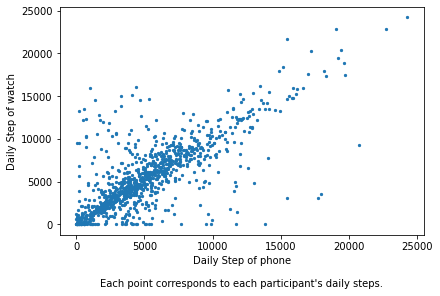

In [95]:
day_sum = data.groupby(['uid',pd.Grouper(key='timestamp', axis=0, freq='D', sort=True), 'device']).sum()
unstacked = day_sum.unstack(level=2)
fig, ax = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)
plt.scatter(unstacked["count"]["phone"], unstacked["count"]["watch"], s = 5)
plt.xlabel('''Daily Step of phone

Each point corresponds to each participant's daily steps.''')
plt.ylabel("Daily Step of watch")
plt.savefig("daily_step_comparison.png")

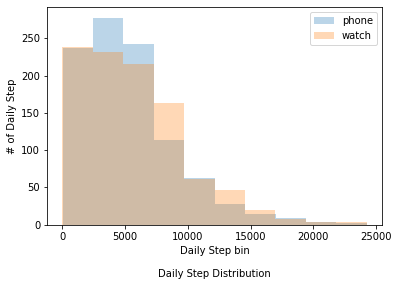

In [96]:
plt.hist(unstacked["count"]["phone"], label="phone", alpha = 0.3)
plt.hist(unstacked["count"]["watch"], label="watch", alpha = 0.3)
plt.legend()
plt.xlabel('''Daily Step bin

Daily Step Distribution''')
plt.ylabel("# of Daily Step")
plt.savefig("daily_step_distribution.png")

In [88]:
import scipy.stats as st
day_phone =np.array(unstacked["count"]["phone"])
day_watch =np.array(unstacked["count"]["watch"])

print(st.normaltest((day_phone-day_watch)/(day_phone + day_watch)*2))
print(st.normaltest((day_phone-day_watch)))

NormaltestResult(statistic=nan, pvalue=nan)
NormaltestResult(statistic=nan, pvalue=nan)


In [97]:
hour_sum = data.groupby(['hour', 'device']).sum()
hour_sum = hour_sum.unstack(level=1)

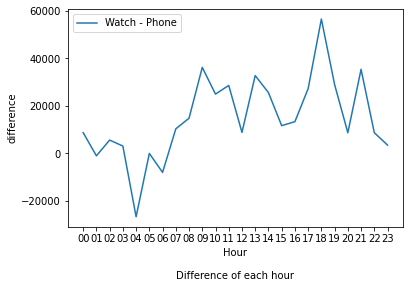

In [98]:
hour_phone = hour_sum["count"]["phone"]
hour_watch = hour_sum["count"]["watch"]
# plt.plot(hour_phone, label = 'phone')
# plt.plot(hour_watch, label = 'watch')
plt.plot(hour_watch - hour_phone, label = 'Watch - Phone')
plt.xticks(range(24), [str(i).zfill(2) for i in range(24)])
plt.legend()
plt.xlabel('''Hour

Difference of each hour''')
plt.ylabel('''difference''')
plt.savefig("total_hourly_difference.png")

In [107]:
day = data.groupby(["uid","day","device"]).sum().unstack(level = 2)["count"]
day.reset_index(inplace = True)
# day = day.groupby("uid")

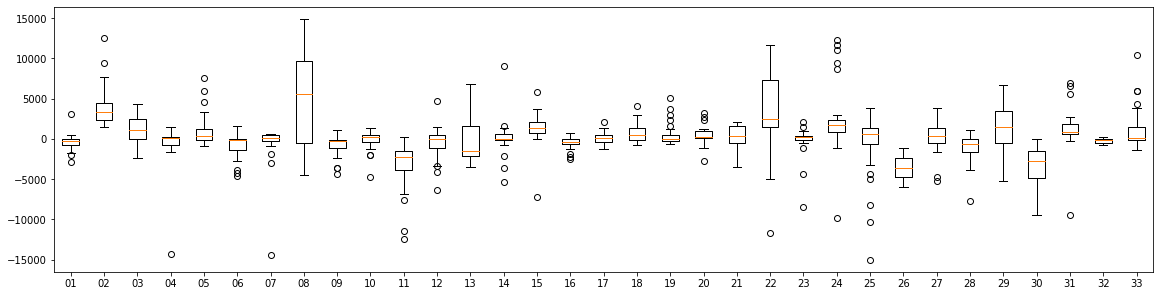

In [112]:
plt.subplots(nrows=1, ncols = 1, constrained_layout = True, figsize = (16,4))
plt.boxplot([np.array(day.query(f"uid == {i}")["watch"]) - np.array(day.query(f"uid == {i}")["phone"]) for i in range(1,34)])
plt.xticks(range(1,34), [str(i).zfill(2) for i in range(1,34)])
plt.savefig("daily_step_box_plot.png")
# plt.plot(np.array(day["watch"])- np.array(day["phone"]), '.')